In [2]:
# enable connection to google drive file system
from google.colab import drive
drive.mount("/content/drive")
# import required modules here
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn import preprocessing

Mounted at /content/drive


In [3]:
# analysis of dataset before basic engineering
path = "/content/drive/My Drive/Colab Notebooks/UFCScraper/bout_statistics.csv"
df = pd.read_csv(path)
print(len(df.index))
print(len(df.columns))
print(df.columns)

6987
57
Index(['card_date', 'card_name', 'red_name', 'blue_name', 'winner_name',
       'loser_name', 'winner_color', 'loser_color', 'match_result',
       'num_rounds', 'time', 'method', 'time_format', 'referee_name',
       'division', 'sig_str_total_red', 'sig_str_landed_red',
       'sig_str_total_blue', 'sig_str_landed_blue', 'total_str_total_red',
       'total_str_landed_red', 'total_str_total_blue', 'total_str_landed_blue',
       'td_total_red', 'td_landed_red', 'td_total_blue', 'td_landed_blue',
       'sub_att_red', 'sub_att_blue', 'rev_red', 'rev_blue', 'ctrl_red',
       'ctrl_blue', 'head_str_total_red', 'head_str_landed_red',
       'head_str_total_blue', 'head_str_landed_blue', 'body_str_total_red',
       'body_str_landed_red', 'body_str_total_blue', 'body_str_landed_blue',
       'leg_str_total_red', 'leg_str_landed_red', 'leg_str_total_blue',
       'leg_str_landed_blue', 'distance_str_total_red',
       'distance_str_landed_red', 'distance_str_total_blue',
       'd

In [4]:
# note: UFC rounds are each 5 minutes long
# SECTION A: BASIC ENGINEERING OF DATASET
path = "/content/drive/My Drive/Colab Notebooks/UFCScraper/bout_statistics.csv"
df = pd.read_csv(path)
# removing columns that are not necessary
df = df.drop(columns=['card_name', 'referee_name', 'winner_name', 'loser_name'])
df['card_date'] = pd.to_datetime(df['card_date'])
# take bouts with the 1 Rnd + OT format out of consideration
df = df.drop(df[df['time_format'] == '1'].index)
df = df.drop(df[df['time_format'] == 'No'].index)
df = df.astype({'time_format':'int'})
# take bouts that ended as no contests out of the dataset as these are anomalies
df = df.drop(df[df['match_result'] == 'NC'].index)
# take bouts that ended in disqualifications as these are anomalies
df = df.drop(df[df['method'] == 'DQ'].index)
# drop rows that are missing statistical values (for the earliest ufc matches)
df = df.drop(df[df['ctrl_red'] == '--'].index)
df = df.drop(df[df['ctrl_blue'] == "--"].index)
# engineer: control time (seconds), max bout duration (seconds), actual bout duration (seconds)
df['ctrl_red'] = df['ctrl_red'].apply(lambda x: 60 * int(x.split(":")[0]) + int(x.split(":")[1]))
df['ctrl_blue'] = df['ctrl_blue'].apply(lambda x: 60 * int(x.split(":")[0]) + int(x.split(":")[1]))
df['max_bout_duration'] = df['time_format'].apply(lambda x: 60 * 5 * x) 
def calc_actual_bout_duration(row): 
  min = int(row['time'].split(":")[0])
  sec = int(row['time'].split(":")[1])
  return 60 * 5 * (row['num_rounds'] - 1) + 60 * min + sec
df['actual_bout_duration'] = df.apply(lambda row: calc_actual_bout_duration(row), axis=1)
df = df.drop(columns=['time', 'num_rounds', 'time_format'])
# engineer: red_win - Yes/No and blue_win - Yes/No. Note: draw means that both red and blue don't win
def return_win(row, red):
  if red == True:
    if row['winner_color'] == 'red':
      return 'Yes'
    else:
      return 'No'
  else:
    if row['winner_color'] == 'blue':
      return 'Yes'
    else:
      return 'No'
df['red_win'] = df.apply(lambda row: return_win(row, red=True), axis=1)
df['blue_win'] = df.apply(lambda row: return_win(row, red=False), axis=1)
df['red_win'] = df['red_win'].astype('category')
df['blue_win'] = df['blue_win'].astype('category')
df = df.drop(columns=['winner_color', 'loser_color', 'match_result'])
# convert method and division into categorical types
df['method'] = df['method'].astype('category')
df['division'] = df['division'].astype('category')

In [5]:
# export basic engineered dataset as csv file
path = "/content/drive/My Drive/Colab Notebooks/UFCScraper/basic_eng_statistics.csv"
df.to_csv(path, index=False)

In [6]:
# SECTION B: CONDUCT PRELIM VISUALIZATION OF BASIC ENGINEERED DATASET
pd.set_option("display.max_rows", None)
with pd.option_context('display.max_columns', 100):
  print(df.info(), "\n")
  print(df.describe(include='all', datetime_is_numeric=True), "\n")
  print(df['method'].value_counts(), "\n")
  print(df['division'].value_counts(), "\n")
  print(df.columns)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6716 entries, 0 to 6806
Data columns (total 51 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   card_date                 6716 non-null   datetime64[ns]
 1   red_name                  6716 non-null   object        
 2   blue_name                 6716 non-null   object        
 3   method                    6716 non-null   category      
 4   division                  6716 non-null   category      
 5   sig_str_total_red         6716 non-null   int64         
 6   sig_str_landed_red        6716 non-null   int64         
 7   sig_str_total_blue        6716 non-null   int64         
 8   sig_str_landed_blue       6716 non-null   int64         
 9   total_str_total_red       6716 non-null   int64         
 10  total_str_landed_red      6716 non-null   int64         
 11  total_str_total_blue      6716 non-null   int64         
 12  total_str_landed_blu

In [7]:
# SECTION C: CUSTOM ENGINEERING OF DATASET (trial 1)
# see how model performs without the inclusion of specific details on significant strikes
# (intuition is that including these features will overfit the model at the expense of other features)
df1 = df.drop(columns=['head_str_total_red', 'head_str_landed_red', 'head_str_total_blue', 'head_str_landed_blue', 
                      'body_str_total_red', 'body_str_landed_red', 'body_str_total_blue', 'body_str_landed_blue', 
                      'leg_str_total_red', 'leg_str_landed_red', 'leg_str_total_blue', 'leg_str_landed_blue',
                      'distance_str_total_red', 'distance_str_landed_red', 'distance_str_total_blue', 'distance_str_landed_blue',
                      'clinch_str_total_red', 'clinch_str_landed_red', 'clinch_str_total_blue', 'clinch_str_landed_blue',
                      'ground_str_total_red', 'ground_str_landed_red', 'ground_str_total_blue', 'ground_str_landed_blue'])
# see how model performs when ignoring fighting division
df1 = df1.drop(columns=['division'])
# transform attack counts to attack rates and success ratios
# (attack rates normalizes raw attack statistics with regards to the time spent fighting)
# (provide a 100% success ratio if an attack of a specified type was never made)
df1['all_str_hit_ratio_red'] = df1.apply(lambda row: 1 if row.total_str_total_red == 0 else row.total_str_landed_red / row.total_str_total_red, axis=1)
df1['all_str_attempt_rate_red'] = df1.apply(lambda row: (row.total_str_total_red / row.actual_bout_duration) * 60, axis=1)
df1['sig_str_hit_ratio_red'] =  df1.apply(lambda row: 1 if row.sig_str_total_red == 0 else row.sig_str_landed_red / row.sig_str_total_red, axis=1)
df1['sig_str_attempt_rate_red'] = df1.apply(lambda row: (row.sig_str_total_red / row.actual_bout_duration) * 60, axis=1)
df1['td_success_ratio_red'] = df1.apply(lambda row: 1 if row.td_total_red == 0 else row.td_landed_red / row.td_total_red, axis=1)
df1['td_attempt_rate_red'] = df1.apply(lambda row: (row.td_total_red / row.actual_bout_duration) * 60, axis=1)
df1['sub_attempt_rate_red'] = df1.apply(lambda row: (row.sub_att_red / row.actual_bout_duration) * 60, axis=1)
df1['all_str_hit_ratio_blue'] = df1.apply(lambda row: 1 if row.total_str_total_blue == 0 else row.total_str_landed_blue / row.total_str_total_blue, axis=1)
df1['all_str_attempt_rate_blue'] = df1.apply(lambda row: (row.total_str_total_blue / row.actual_bout_duration) * 60, axis=1)
df1['sig_str_hit_ratio_blue'] =  df1.apply(lambda row: 1 if row.sig_str_total_blue == 0 else row.sig_str_landed_blue / row.sig_str_total_blue, axis=1)
df1['sig_str_attempt_rate_blue'] = df1.apply(lambda row: (row.sig_str_total_blue / row.actual_bout_duration) * 60, axis=1)
df1['td_success_ratio_blue'] = df1.apply(lambda row: 1 if row.td_total_blue == 0 else row.td_landed_blue / row.td_total_blue, axis=1)
df1['td_attempt_rate_blue'] = df1.apply(lambda row: (row.td_total_blue / row.actual_bout_duration) * 60, axis=1)
df1['sub_attempt_rate_blue'] = df1.apply(lambda row: (row.sub_att_blue / row.actual_bout_duration) * 60, axis=1)
# transform time spent fighting and control time to ratios
# (ratio normalizes raw time statistics with regards to different round formats)
df1['ctrl_time_ratio_red'] = df1.apply(lambda row: row.ctrl_red / row.actual_bout_duration, axis=1)
df1['ctrl_time_ratio_blue'] = df1.apply(lambda row: row.ctrl_blue / row.actual_bout_duration, axis=1)
df1['prop_match_completed'] = df1.apply(lambda row: row.actual_bout_duration / row.max_bout_duration, axis=1)
# aggregate win method into groups and one hot encode the win method
df1['method'].replace(to_replace=['KO/TKO', 'TKO - Doctor\'s Stoppage'], value=['KO/TKO', 'KO/TKO'], inplace=True)
df1['method'].replace(to_replace=['Decision - Split', 'Decision - Majority'], value=['NU_Decision', 'NU_Decision'], inplace=True)
df1['method'].replace(to_replace=['Decision - Unanimous'], value=['U_Decision'], inplace=True)
# drop remaining columns that are not needed
df1 = df1.drop(columns=['sig_str_total_red', 'sig_str_landed_red', 'sig_str_total_blue', 'sig_str_landed_blue',
                  'total_str_total_red', 'total_str_landed_red', 'total_str_total_blue', 'total_str_landed_blue', 
                  'td_total_red', 'td_landed_red', 'td_total_blue', 'td_landed_blue', 
                  'sub_att_red', 'sub_att_blue', 'rev_red', 'rev_blue', 'ctrl_red', 'ctrl_blue', 
                  'max_bout_duration', 'actual_bout_duration'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6716 entries, 0 to 6806
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   card_date                  6716 non-null   datetime64[ns]
 1   red_name                   6716 non-null   object        
 2   blue_name                  6716 non-null   object        
 3   method                     6716 non-null   category      
 4   red_win                    6716 non-null   category      
 5   blue_win                   6716 non-null   category      
 6   all_str_hit_ratio_red      6716 non-null   float64       
 7   all_str_attempt_rate_red   6716 non-null   float64       
 8   sig_str_hit_ratio_red      6716 non-null   float64       
 9   sig_str_attempt_rate_red   6716 non-null   float64       
 10  td_success_ratio_red       6716 non-null   float64       
 11  td_attempt_rate_red        6716 non-null   float64       
 12  sub_at

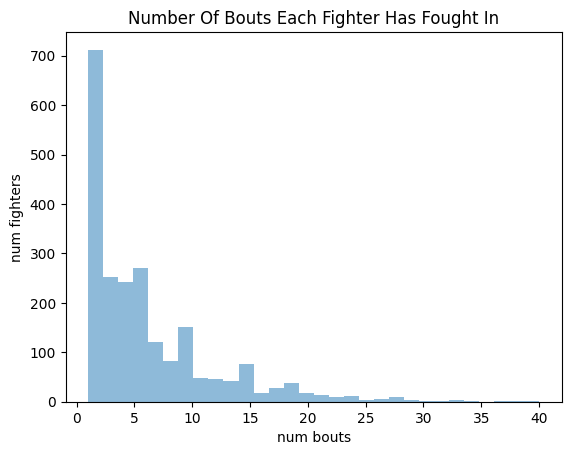

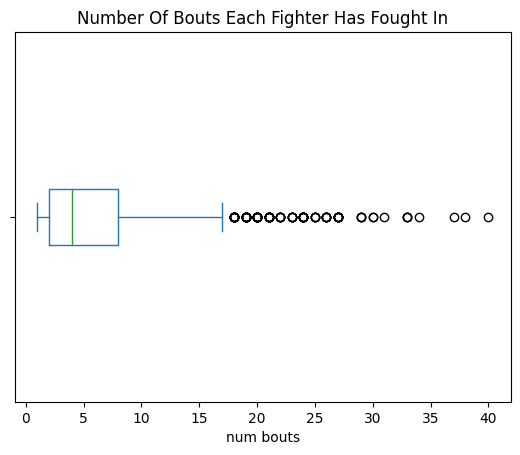

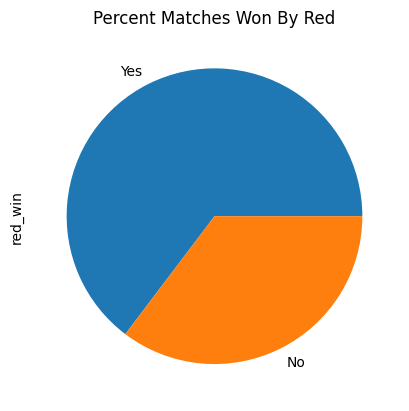

65%


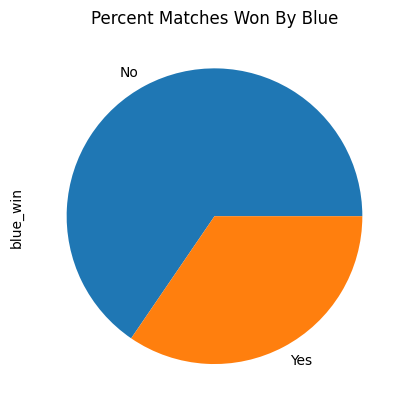

35%


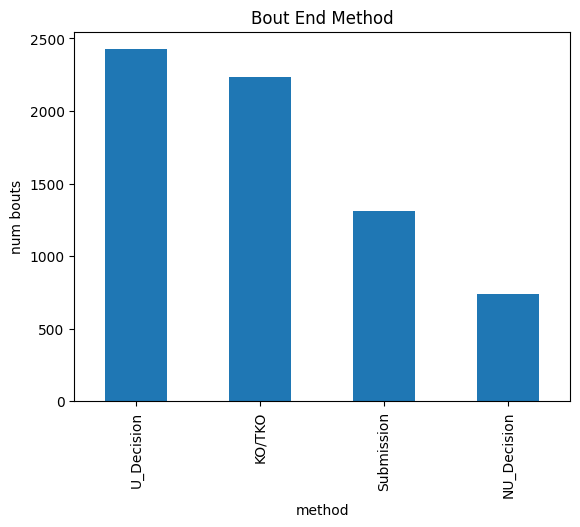

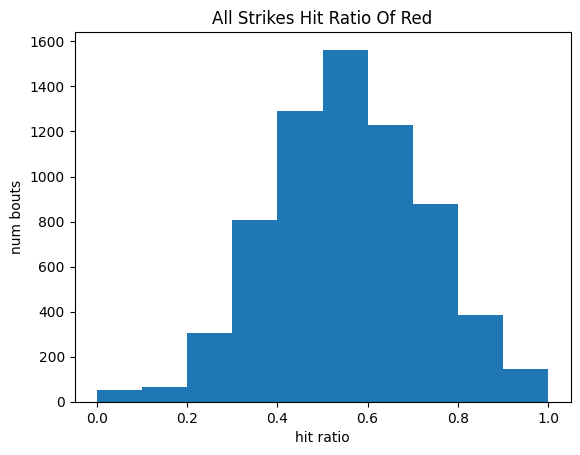

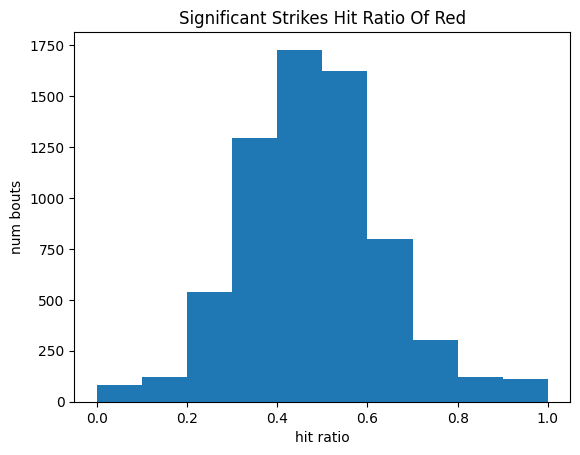

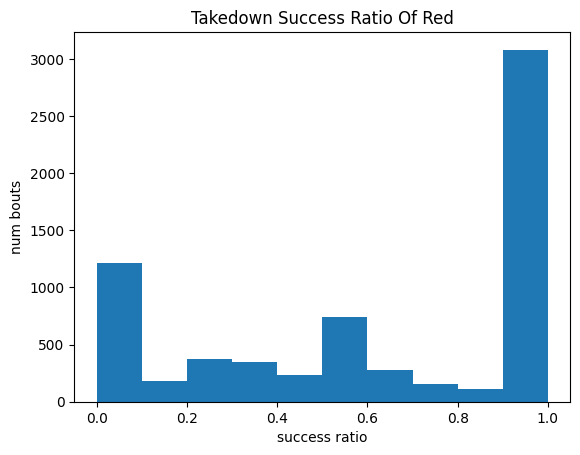

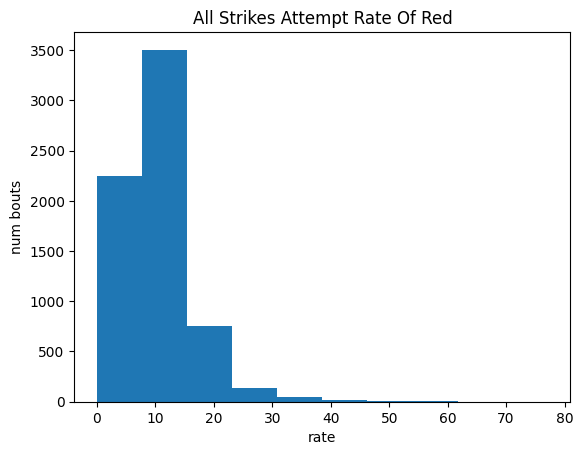

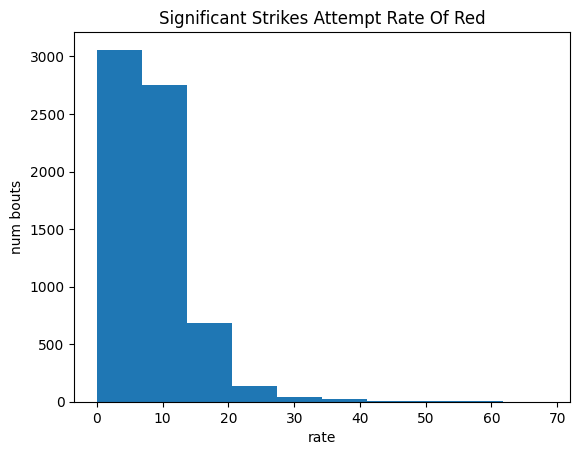

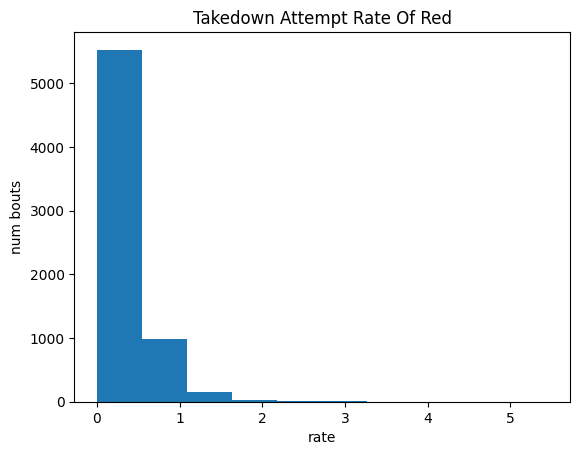

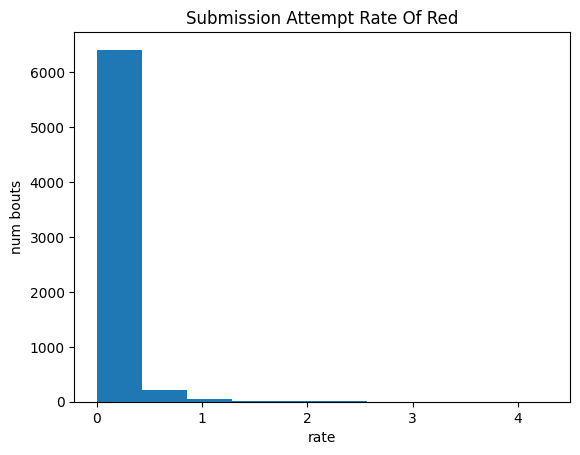

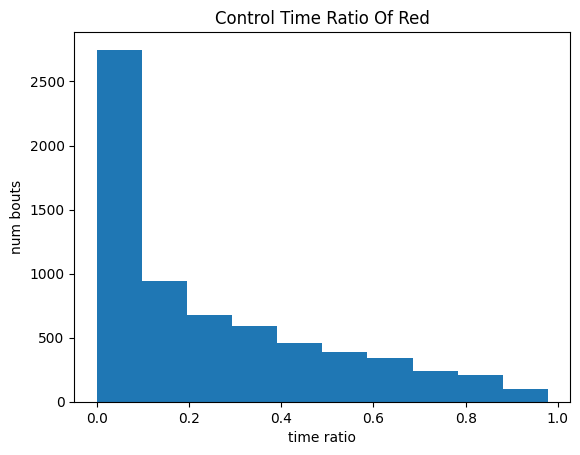

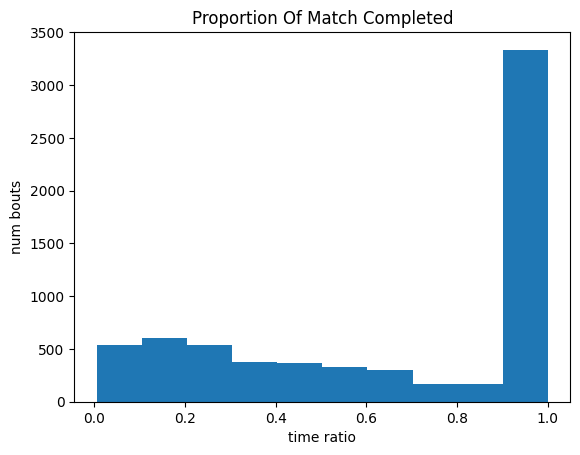

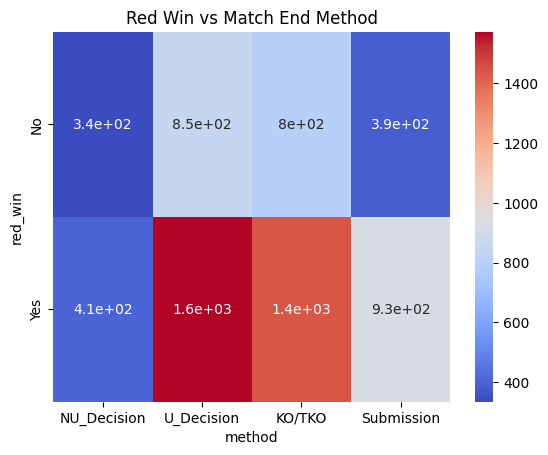

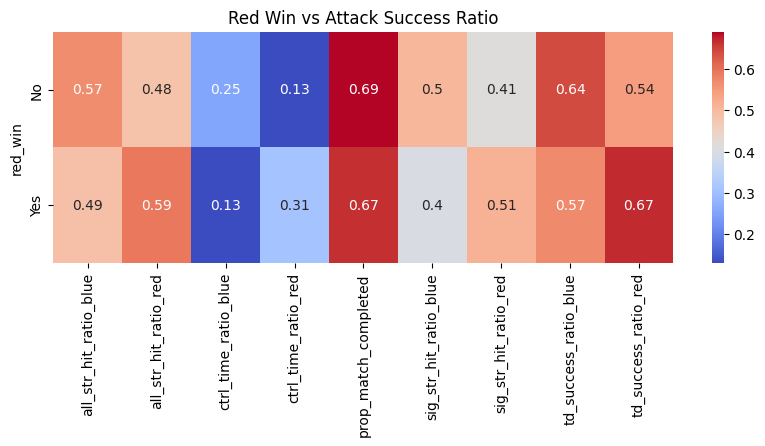

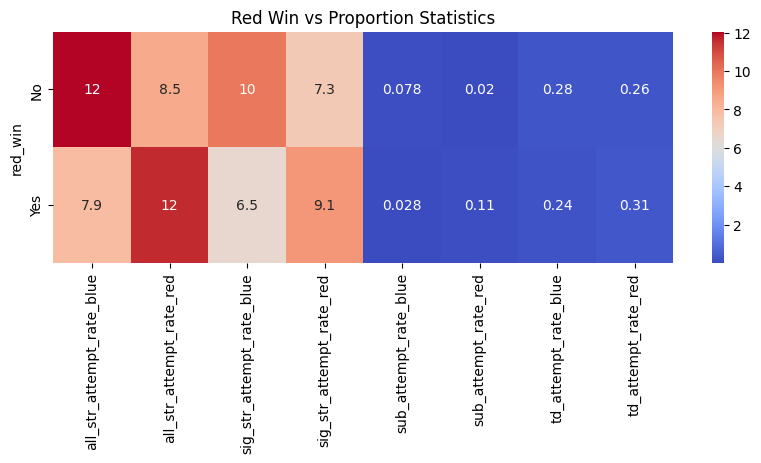

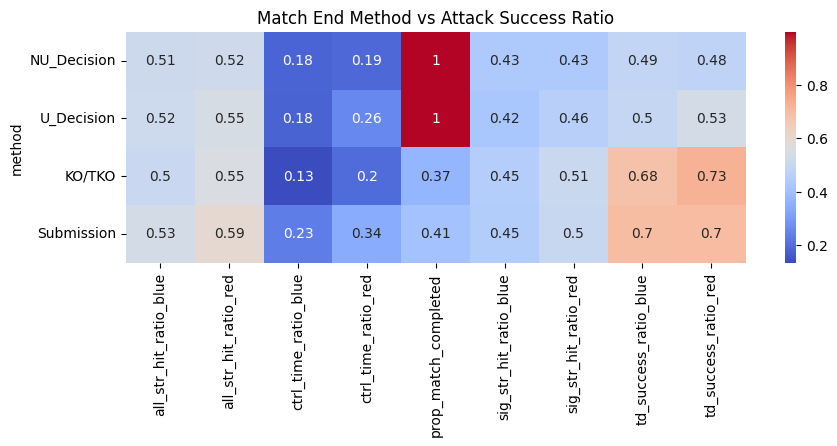

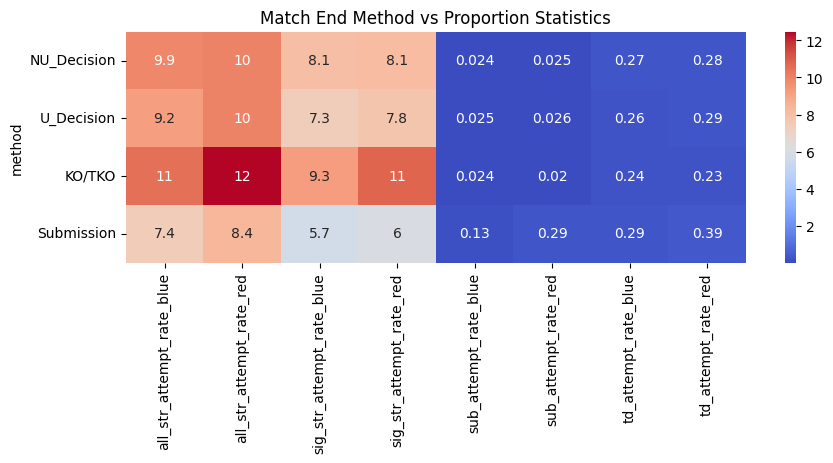

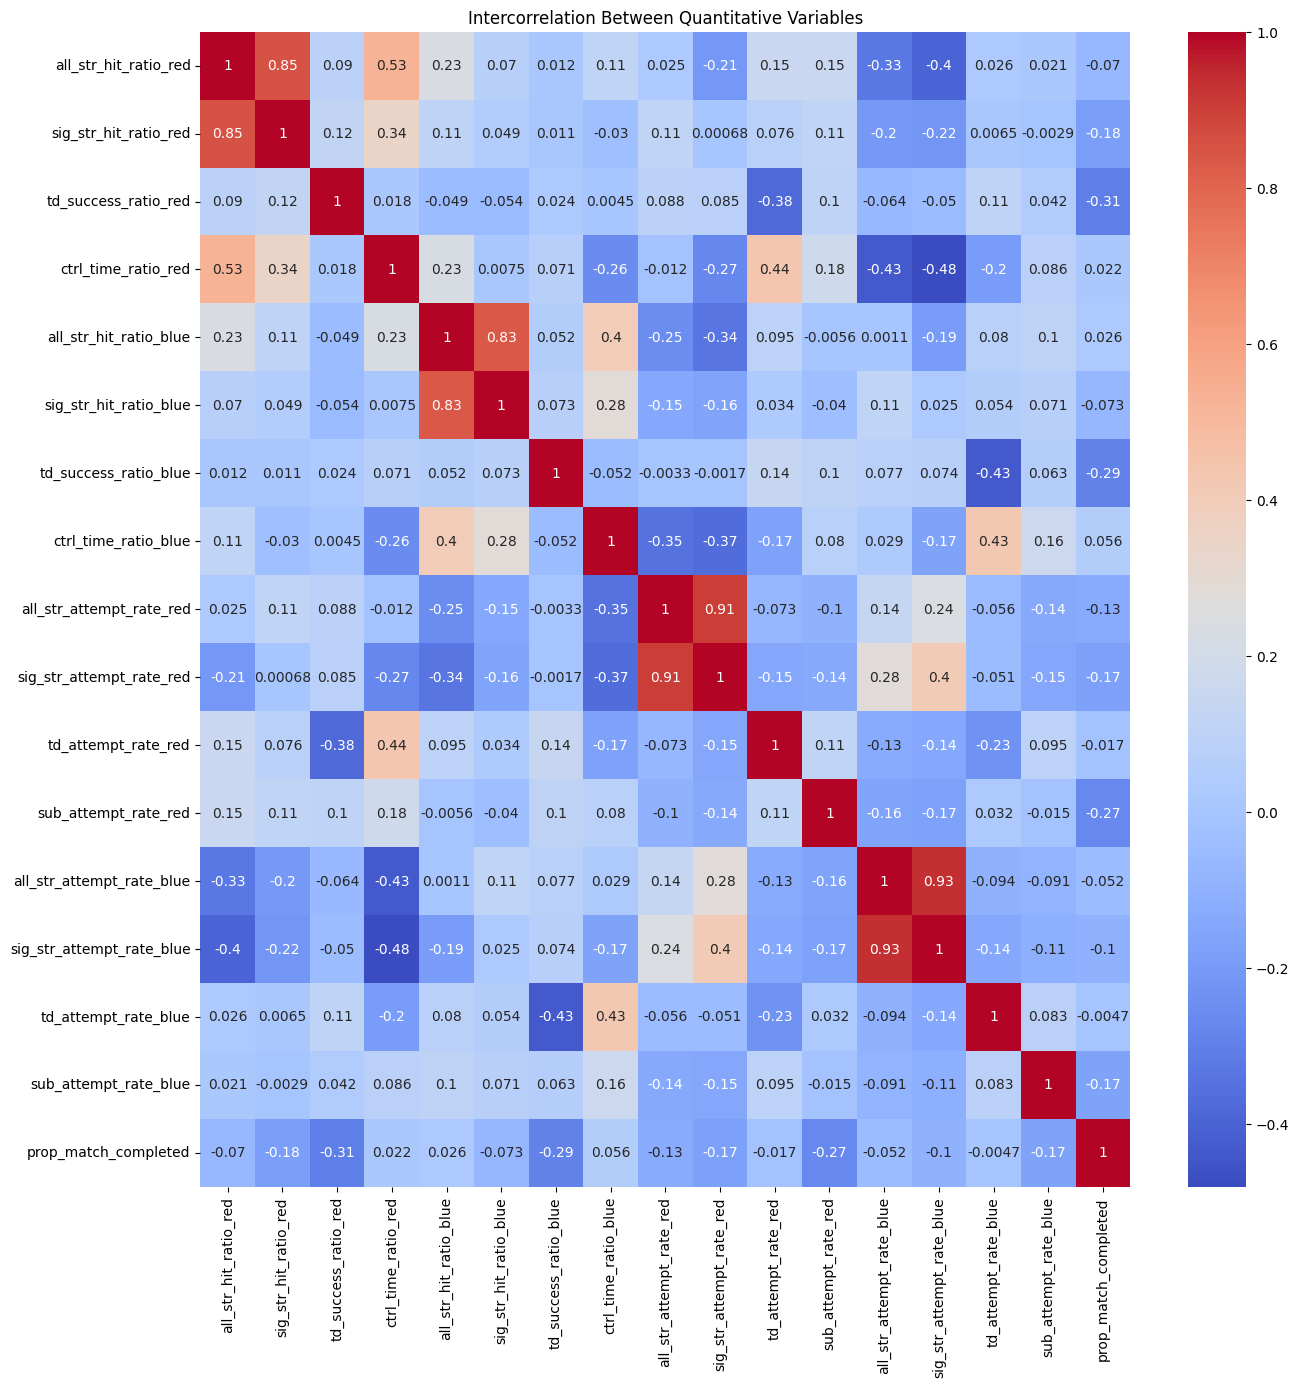

In [9]:
# SECTION D: CONDUCT VISUALIZATION AND UNDERSTANDING OF CUSTOM ENGINEERED DATASET (trial 1)
pd.set_option("display.max_rows", None)
with pd.option_context('display.max_columns', 100):
  print(df1.info(), "\n")
  print(df1.describe(include='all', datetime_is_numeric=True), "\n")
  pass
# make a histogram of the number of bouts each fighter has participated in
ax = pd.concat([df1['red_name'], df1['blue_name']]).value_counts().plot.hist(alpha=0.5, bins=30)
ax.set_title("Number Of Bouts Each Fighter Has Fought In")
plt.xlabel("num bouts")
plt.ylabel("num fighters")
plt.show()
ax = pd.concat([df1['red_name'], df1['blue_name']]).value_counts().plot.box(vert=False)
ax.set_title("Number Of Bouts Each Fighter Has Fought In")
plt.xlabel("num bouts")
plt.show()
# make a histogram of red win vs blue win
ax = df1['red_win'].value_counts().plot.pie()
ax.set_title("Percent Matches Won By Red")
plt.show()
print(f"{round((df1['red_win'].value_counts()[0] / df1['red_win'].value_counts().sum()) * 100)}%")
ax = df1['blue_win'].value_counts().plot.pie()
ax.set_title("Percent Matches Won By Blue")
plt.show()
print(f"{round((df1['blue_win'].value_counts()[1] / df1['red_win'].value_counts().sum()) * 100)}%")
# make a bar chart of the method by which the bout was ended
ax = df1['method'].value_counts().plot.bar()
ax.set_title("Bout End Method")
plt.xlabel("method")
plt.ylabel("num bouts")
plt.show()
# make histograms of red's attack success ratio
ax = df1['all_str_hit_ratio_red'].plot.hist()
ax.set_title("All Strikes Hit Ratio Of Red")
plt.xlabel("hit ratio")
plt.ylabel("num bouts")
plt.show()
ax = df1['sig_str_hit_ratio_red'].plot.hist()
ax.set_title("Significant Strikes Hit Ratio Of Red")
plt.xlabel("hit ratio")
plt.ylabel("num bouts")
plt.show()
ax = df1['td_success_ratio_red'].plot.hist()
ax.set_title("Takedown Success Ratio Of Red")
plt.xlabel("success ratio")
plt.ylabel("num bouts")
plt.show()
# make histograms of red's attack rate
ax = df1['all_str_attempt_rate_red'].plot.hist()
ax.set_title("All Strikes Attempt Rate Of Red")
plt.xlabel("rate")
plt.ylabel("num bouts")
plt.show()
ax = df1['sig_str_attempt_rate_red'].plot.hist()
ax.set_title("Significant Strikes Attempt Rate Of Red")
plt.xlabel("rate")
plt.ylabel("num bouts")
plt.show()
ax = df1['td_attempt_rate_red'].plot.hist()
ax.set_title("Takedown Attempt Rate Of Red")
plt.xlabel("rate")
plt.ylabel("num bouts")
plt.show()
ax = df1['sub_attempt_rate_red'].plot.hist()
ax.set_title("Submission Attempt Rate Of Red")
plt.xlabel("rate")
plt.ylabel("num bouts")
plt.show()
# make histogram of red's control time ratio
ax = df1['ctrl_time_ratio_red'].plot.hist()
ax.set_title("Control Time Ratio Of Red")
plt.xlabel("time ratio")
plt.ylabel("num bouts")
plt.show()
# make histogram of match completion ratio
ax = df1['prop_match_completed'].plot.hist()
ax.set_title("Proportion Of Match Completed")
plt.xlabel("time ratio")
plt.ylabel("num bouts")
plt.show()
# make a heatmap of red win vs match end method
table = pd.crosstab(df['red_win'], df['method'])
sns.heatmap(table, annot=True, cmap='coolwarm')
plt.title("Red Win vs Match End Method")
plt.show()
# make a heatmap of red win vs all other quantitative statistics
table = pd.pivot_table(df1, values=[
    'all_str_hit_ratio_red', 'sig_str_hit_ratio_red', 'td_success_ratio_red', 'ctrl_time_ratio_red',
    'all_str_hit_ratio_blue', 'sig_str_hit_ratio_blue', 'td_success_ratio_blue', 'ctrl_time_ratio_blue',
    'prop_match_completed'], index=['red_win'], aggfunc='mean')
plt.figure(figsize=(10, 3))
sns.heatmap(table, annot=True, cmap='coolwarm')
plt.title("Red Win vs Attack Success Ratio")
plt.show()
table = pd.pivot_table(df1, values=[
    'all_str_attempt_rate_red', 'sig_str_attempt_rate_red', 'td_attempt_rate_red', 'sub_attempt_rate_red',
    'all_str_attempt_rate_blue', 'sig_str_attempt_rate_blue', 'td_attempt_rate_blue', 'sub_attempt_rate_blue'
    ], index=['red_win'], aggfunc='mean')
plt.figure(figsize=(10, 3))
sns.heatmap(table, annot=True, cmap='coolwarm')
plt.title("Red Win vs Proportion Statistics")
plt.show()
# make a heatmap between match end method vs all other quantitative statistics
table = pd.pivot_table(df1, values=[
    'all_str_hit_ratio_red', 'sig_str_hit_ratio_red', 'td_success_ratio_red', 'ctrl_time_ratio_red',
    'all_str_hit_ratio_blue', 'sig_str_hit_ratio_blue', 'td_success_ratio_blue', 'ctrl_time_ratio_blue',
    'prop_match_completed'], index=['method'], aggfunc='mean')
plt.figure(figsize=(10, 3))
sns.heatmap(table, annot=True, cmap='coolwarm')
plt.title("Match End Method vs Attack Success Ratio")
plt.show()
table = pd.pivot_table(df1, values=[
    'all_str_attempt_rate_red', 'sig_str_attempt_rate_red', 'td_attempt_rate_red', 'sub_attempt_rate_red',
    'all_str_attempt_rate_blue', 'sig_str_attempt_rate_blue', 'td_attempt_rate_blue', 'sub_attempt_rate_blue'
    ], index=['method'], aggfunc='mean')
plt.figure(figsize=(10, 3))
sns.heatmap(table, annot=True, cmap='coolwarm')
plt.title("Match End Method vs Proportion Statistics")
plt.show()
# make a correlative heatmap within quantitative statistics
cm = df1[['all_str_hit_ratio_red', 'sig_str_hit_ratio_red', 'td_success_ratio_red', 'ctrl_time_ratio_red',
    'all_str_hit_ratio_blue', 'sig_str_hit_ratio_blue', 'td_success_ratio_blue', 'ctrl_time_ratio_blue',
    'all_str_attempt_rate_red', 'sig_str_attempt_rate_red', 'td_attempt_rate_red', 'sub_attempt_rate_red',
    'all_str_attempt_rate_blue', 'sig_str_attempt_rate_blue', 'td_attempt_rate_blue', 'sub_attempt_rate_blue',
    'prop_match_completed']].corr()
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, cmap='coolwarm')
plt.title("Intercorrelation Between Quantitative Variables")
plt.show()

In [ ]:
df11 = df1.copy()
print(df11.columns)
# label encode red win and blue win
df11['red_win'] = df11['red_win'].cat.codes
df11['blue_win'] = df11['blue_win'].cat.codes
# one hot encode the match end method
df11 = pd.get_dummies(df11, columns=['method'])
# predict which variables will be the most useful for predicting match result
X = df11.drop(columns=['red_win', 'blue_win', 'card_date', 'red_name', 'blue_name'])
y = df11['red_win']
selector = SelectKBest(score_func=mutual_info_classif, k=10)
selector.fit_transform(X, y)
scores = selector.scores_
ranked_features = X.columns[np.argsort(-scores)]
print()
print("Feature ranking:")
for i, feature in enumerate(ranked_features):
    print("%d. %s (%f)" % (i+1, feature, scores[X.columns.get_loc(feature)]))

Index(['card_date', 'red_name', 'blue_name', 'method', 'red_win', 'blue_win',
       'all_str_hit_ratio_red', 'all_str_attempt_rate_red',
       'sig_str_hit_ratio_red', 'sig_str_attempt_rate_red',
       'td_success_ratio_red', 'td_attempt_rate_red', 'sub_attempt_rate_red',
       'all_str_hit_ratio_blue', 'all_str_attempt_rate_blue',
       'sig_str_hit_ratio_blue', 'sig_str_attempt_rate_blue',
       'td_success_ratio_blue', 'td_attempt_rate_blue',
       'sub_attempt_rate_blue', 'ctrl_time_ratio_red', 'ctrl_time_ratio_blue',
       'prop_match_completed'],
      dtype='object')

Feature ranking:
1. ctrl_time_ratio_red (0.082975)
2. sig_str_hit_ratio_blue (0.075401)
3. all_str_attempt_rate_blue (0.074939)
4. sig_str_attempt_rate_blue (0.061036)
5. sig_str_hit_ratio_red (0.058079)
6. ctrl_time_ratio_blue (0.056550)
7. all_str_attempt_rate_red (0.055516)
8. all_str_hit_ratio_red (0.046828)
9. all_str_hit_ratio_blue (0.045840)
10. sub_attempt_rate_red (0.045554)
11. td_success_ratio_bl

In [ ]:
# export custom engineered dataset as csv file
path = "/content/drive/My Drive/Colab Notebooks/UFCScraper/custom_eng_statistics_1.csv"
df11.to_csv(path, index=False)

In [ ]:
# SECTION E: TRAIN MODEL AND TEST USING PROPHETIC DATA
# metrics when using 2 grappling only features
train_df11, test_df11 = train_test_split(df11, test_size=0.2, random_state=50)
X_train = train_df11[['ctrl_time_ratio_red', 'ctrl_time_ratio_blue']]
y_train = train_df11['red_win']
X_test = test_df11[['ctrl_time_ratio_red', 'ctrl_time_ratio_blue']]
y_test = test_df11['red_win']
model = LogisticRegression(random_state=50)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = accuracy_score(y_test, y_pred)
print("Metrics (4 custom control only)")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print()
# metrics when using 4 striking only features
train_df11, test_df11 = train_test_split(df11, test_size=0.2, random_state=50)
X_train = train_df11[['all_str_attempt_rate_blue', 'all_str_attempt_rate_red', 
                      'all_str_hit_ratio_blue', 'all_str_hit_ratio_red']]
y_train = train_df11['red_win']
X_test = test_df11[['all_str_attempt_rate_blue', 'all_str_attempt_rate_red',
                    'all_str_hit_ratio_blue', 'all_str_hit_ratio_red']]
y_test = test_df11['red_win']
model = LogisticRegression(random_state=50)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = accuracy_score(y_test, y_pred)
print("Metrics (4 custom striking only)")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print()
# metrics when using 4 success only features
train_df11, test_df11 = train_test_split(df11, test_size=0.2, random_state=50)
X_train = train_df11[['ctrl_time_ratio_red', 'ctrl_time_ratio_blue',  
                      'all_str_hit_ratio_blue', 'all_str_hit_ratio_red']]
y_train = train_df11['red_win']
X_test = test_df11[['ctrl_time_ratio_red', 'ctrl_time_ratio_blue',
                    'all_str_hit_ratio_blue', 'all_str_hit_ratio_red']]
y_test = test_df11['red_win']
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = accuracy_score(y_test, y_pred)
print("Metrics (4 custom success only)")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print()
# metrics when using 6 custom selected features
train_df11, test_df11 = train_test_split(df11, test_size=0.2, random_state=50)
X_train = train_df11[['ctrl_time_ratio_red', 'ctrl_time_ratio_blue', 'all_str_attempt_rate_blue', 
        'all_str_attempt_rate_red', 'all_str_hit_ratio_blue', 'all_str_hit_ratio_red']]
y_train = train_df11['red_win']
X_test = test_df11[['ctrl_time_ratio_red', 'ctrl_time_ratio_blue', 'all_str_attempt_rate_blue', 
        'all_str_attempt_rate_red', 'all_str_hit_ratio_blue', 'all_str_hit_ratio_red']]
y_test = test_df11['red_win']
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = accuracy_score(y_test, y_pred)
print("Metrics (6 custom striking + control)")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print()
# metrics when selecting top 6 features from feature selection
train_df11, test_df11 = train_test_split(df11, test_size=0.2)
X_train = train_df11[['ctrl_time_ratio_red', 'all_str_attempt_rate_blue', 'sig_str_hit_ratio_blue', 
        'sig_str_attempt_rate_blue', 'sig_str_hit_ratio_red', 'ctrl_time_ratio_blue']]
y_train = train_df11['red_win']
X_test = test_df11[['ctrl_time_ratio_red', 'all_str_attempt_rate_blue', 'sig_str_hit_ratio_blue', 
        'sig_str_attempt_rate_blue', 'sig_str_hit_ratio_red', 'ctrl_time_ratio_blue']]
y_test = test_df11['red_win']
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = accuracy_score(y_test, y_pred)
print("Metrics (6 via fs)")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print()
# metrics when using 10 custom selected features
train_df11, test_df11 = train_test_split(df11, test_size=0.2)
X_train = train_df11[['ctrl_time_ratio_red', 'ctrl_time_ratio_blue', 'all_str_attempt_rate_blue', 
        'all_str_attempt_rate_red', 'all_str_hit_ratio_blue', 'all_str_hit_ratio_red',
        'sub_attempt_rate_red', 'sub_attempt_rate_blue', 'td_success_ratio_red', 'td_success_ratio_blue']]
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
y_train = train_df11['red_win']
X_test = test_df11[['ctrl_time_ratio_red', 'ctrl_time_ratio_blue', 'all_str_attempt_rate_blue', 
        'all_str_attempt_rate_red', 'all_str_hit_ratio_blue', 'all_str_hit_ratio_red',
        'sub_attempt_rate_red', 'sub_attempt_rate_blue', 'td_success_ratio_red', 'td_success_ratio_blue']]
scaler = preprocessing.StandardScaler().fit(X_test)
X_test_scaled = scaler.transform(X_test)
y_test = test_df11['red_win']
model = LogisticRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = accuracy_score(y_test, y_pred)
print("Metrics (10 custom): ")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print()
# metrics when selecting top 10 features from feature selection
train_df11, test_df11 = train_test_split(df11, test_size=0.2)
X_train = train_df11[['ctrl_time_ratio_red', 'all_str_attempt_rate_blue', 'sig_str_hit_ratio_blue', 
        'sig_str_attempt_rate_blue', 'sig_str_hit_ratio_red', 'ctrl_time_ratio_blue', 'all_str_attempt_rate_red',
        'all_str_hit_ratio_blue', 'all_str_hit_ratio_red', 'sub_attempt_rate_red']]
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
y_train = train_df11['red_win']
X_test = test_df11[['ctrl_time_ratio_red', 'all_str_attempt_rate_blue', 'sig_str_hit_ratio_blue', 
        'sig_str_attempt_rate_blue', 'sig_str_hit_ratio_red', 'ctrl_time_ratio_blue', 'all_str_attempt_rate_red',
        'all_str_hit_ratio_blue', 'all_str_hit_ratio_red', 'sub_attempt_rate_red']]
scaler = preprocessing.StandardScaler().fit(X_test)
X_test_scaled = scaler.transform(X_test)
y_test = test_df11['red_win']
model = LogisticRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = accuracy_score(y_test, y_pred)
print("Metrics (10 via fs)")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Metrics (4 custom control only)
Accuracy: 0.7090773809523809
Precision: 0.7220149253731343
Recall: 0.7090773809523809

Metrics (4 custom striking only)
Accuracy: 0.7738095238095238
Precision: 0.7829145728643216
Recall: 0.7738095238095238

Metrics (4 custom success only)
Accuracy: 0.7596726190476191
Precision: 0.7714570858283433
Recall: 0.7596726190476191

Metrics (6 custom striking + control)
Accuracy: 0.7834821428571429
Precision: 0.7962962962962963
Recall: 0.7834821428571429

Metrics (6 via fs)
Accuracy: 0.796875
Precision: 0.8099173553719008
Recall: 0.796875

Metrics (10 custom): 
Accuracy: 0.8407738095238095
Precision: 0.8662983425414365
Recall: 0.8407738095238095

Metrics (10 via fs)
Accuracy: 0.8370535714285714
Precision: 0.8554083885209713
Recall: 0.8370535714285714


In [ ]:
# TESTING ADDITIONAL MODELS ON THE DATASET
# testing with 10 custom features
train_df11, test_df11 = train_test_split(df11, test_size=0.2)
X_train = train_df11[['ctrl_time_ratio_red', 'ctrl_time_ratio_blue', 'all_str_attempt_rate_blue', 
        'all_str_attempt_rate_red', 'all_str_hit_ratio_blue', 'all_str_hit_ratio_red',
        'sub_attempt_rate_red', 'sub_attempt_rate_blue', 'td_success_ratio_red', 'td_success_ratio_blue']]
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
y_train = train_df11['red_win']
X_test = test_df11[['ctrl_time_ratio_red', 'ctrl_time_ratio_blue', 'all_str_attempt_rate_blue', 
        'all_str_attempt_rate_red', 'all_str_hit_ratio_blue', 'all_str_hit_ratio_red',
        'sub_attempt_rate_red', 'sub_attempt_rate_blue', 'td_success_ratio_red', 'td_success_ratio_blue']]
scaler = preprocessing.StandardScaler().fit(X_test)
X_test_scaled = scaler.transform(X_test)
y_test = test_df11['red_win']
# testing with logistic regression
model = LogisticRegression()
model.fit(X_train_scaled, y_train)
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="accuracy")
mean_cv = cv_scores.mean()
print("Training Accuracy Logistic Regression")
print("Accuracy:", mean_cv)
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = accuracy_score(y_test, y_pred)
print("Logistic Regression Results")
print("Metrics (10 custom): ")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print()
# testing with support vector machine
model = svm.SVC()
model.fit(X_train_scaled, y_train)
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="accuracy")
mean_cv = cv_scores.mean()
print("Training Accuracy Support Vector Machine")
print("Accuracy:", mean_cv)
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = accuracy_score(y_test, y_pred)
print("Support Vector Machine Results")
print("Metrics (10 custom): ")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print()
# testing with random forests
model = RandomForestClassifier()
model.fit(X_train_scaled, y_train)
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="accuracy")
mean_cv = cv_scores.mean()
print("Training Accuracy Random Forests")
print("Accuracy:", mean_cv)
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = accuracy_score(y_test, y_pred)
print("Random Forests Results")
print("Metrics (10 custom): ")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print()

Training Accuracy Logistic Regression
Accuracy: 0.8341410939327011
Logistic Regression Results
Metrics (10 custom): 
Accuracy: 0.8229166666666666
Precision: 0.8309705561613958
Recall: 0.8229166666666666

Training Accuracy Support Vector Machine
Accuracy: 0.840468927287688
Support Vector Machine Results
Metrics (10 custom): 
Accuracy: 0.8214285714285714
Precision: 0.8298800436205016
Recall: 0.8214285714285714

Training Accuracy Random Forests
Accuracy: 0.8391646962019834
Random Forests Results
Metrics (10 custom): 
Accuracy: 0.8229166666666666
Precision: 0.8302502720348205
Recall: 0.8229166666666666



In [ ]:
# 1.5 MINUTES TO RUN
# SECTION F: ENGINEER DATASET OF PRIORS (trial 1 + via mean imputation)
path = "/content/drive/My Drive/Colab Notebooks/UFCScraper/custom_eng_statistics_1.csv"
new_df11 = pd.read_csv(path)
# remove prophetic information from imputation dataframe
df1i = new_df11.drop(columns=['all_str_hit_ratio_red', 'all_str_attempt_rate_red',
                          'sig_str_hit_ratio_red', 'sig_str_attempt_rate_red', 'td_success_ratio_red', 
                          'td_attempt_rate_red', 'sub_attempt_rate_red', 'all_str_hit_ratio_blue', 
                          'all_str_attempt_rate_blue', 'sig_str_hit_ratio_blue', 'sig_str_attempt_rate_blue',
                          'td_success_ratio_blue', 'td_attempt_rate_blue', 'sub_attempt_rate_blue', 
                          'ctrl_time_ratio_red', 'ctrl_time_ratio_blue', 'prop_match_completed', 
                          'method_NU_Decision', 'method_U_Decision', 'method_KO/TKO', 'method_Submission'])
# red fighter's features to be imputed
df1i['num_fights_red'] = np.zeros(len(new_df11))
df1i['prop_wins_red'] = np.zeros(len(new_df11))
df1i['imp_all_str_hit_ratio_red'] = np.zeros(len(new_df11))
df1i['imp_all_str_attempt_rate_red'] = np.zeros(len(new_df11))
df1i['imp_sig_str_hit_ratio_red'] = np.zeros(len(new_df11))
df1i['imp_sig_str_attempt_rate_red'] = np.zeros(len(new_df11))
df1i['imp_td_success_ratio_red'] = np.zeros(len(new_df11))
df1i['imp_td_attempt_rate_red'] = np.zeros(len(new_df11))
df1i['imp_ctrl_time_ratio_red'] = np.zeros(len(new_df11))
df1i['imp_prop_match_completed_red'] = np.zeros(len(new_df11))
df1i['imp_num_win_NU_Decision_red'] = np.zeros(len(new_df11))
df1i['imp_num_win_U_Decision_red'] = np.zeros(len(new_df11))
df1i['imp_num_win_KO/TKO_red'] = np.zeros(len(new_df11))
df1i['imp_num_win_Submission_red'] = np.zeros(len(new_df11))
# blue fighter's features to be imputed
df1i['num_fights_blue'] = np.zeros(len(new_df11))
df1i['prop_wins_blue'] = np.zeros(len(new_df11))
df1i['imp_all_str_hit_ratio_blue'] = np.zeros(len(new_df11))
df1i['imp_all_str_attempt_rate_blue'] = np.zeros(len(new_df11))
df1i['imp_sig_str_hit_ratio_blue'] = np.zeros(len(new_df11))
df1i['imp_sig_str_attempt_rate_blue'] = np.zeros(len(new_df11))
df1i['imp_td_success_ratio_blue'] = np.zeros(len(new_df11))
df1i['imp_td_attempt_rate_blue'] = np.zeros(len(new_df11))
df1i['imp_ctrl_time_ratio_blue'] = np.zeros(len(new_df11))
df1i['imp_prop_match_completed_blue'] = np.zeros(len(new_df11))
df1i['imp_num_win_NU_Decision_blue'] = np.zeros(len(new_df11))
df1i['imp_num_win_U_Decision_blue'] = np.zeros(len(new_df11))
df1i['imp_num_win_KO/TKO_blue'] = np.zeros(len(new_df11))
df1i['imp_num_win_Submission_blue'] = np.zeros(len(new_df11))
# iterate through all rows of df1i, extracting from df1: previous stats for red_name and for blue_name
for index, row in df1i.iterrows():
  # extract rows from prophetic dataframe relevant to red_name
  red_df = new_df11.loc[(new_df11['card_date'] < row['card_date']) & ((new_df11['red_name'] == row['red_name']) | (new_df11['blue_name'] == row['red_name']))]
  red_win_df = red_df.loc[((red_df['red_name'] == row['red_name']) & (red_df['red_win'] == 1)) | ((red_df['blue_name'] == row['red_name']) & (red_df['blue_win']) == 1)]
  # use extracted rows to impute mean features
  num_fights_red = red_df.shape[0]
  num_wins_red = red_win_df.shape[0]
  df1i.loc[index, 'num_fights_red'] = num_fights_red
  if num_fights_red > 0:
    imp_all_str_hit_ratio_red = 0
    imp_all_str_attempt_rate_red = 0
    imp_sig_str_hit_ratio_red = 0
    imp_sig_str_attempt_rate_red = 0
    imp_td_success_ratio_red = 0
    imp_td_attempt_rate_red = 0
    imp_ctrl_time_ratio_red = 0
    imp_prop_match_completed_red = 0
    df1i.loc[index, 'prop_wins_red'] = num_wins_red / num_fights_red
    for index2, row2 in red_df.iterrows():
      if row2['red_name'] == row['red_name']:
        imp_all_str_hit_ratio_red += row2['all_str_hit_ratio_red']
        imp_all_str_attempt_rate_red += row2['all_str_attempt_rate_red']
        imp_sig_str_hit_ratio_red += row2['sig_str_hit_ratio_red']
        imp_sig_str_attempt_rate_red += row2['sig_str_attempt_rate_red']
        imp_td_success_ratio_red += row2['td_success_ratio_red']
        imp_td_attempt_rate_red += row2['td_attempt_rate_red']
        imp_ctrl_time_ratio_red += row2['ctrl_time_ratio_red']
      elif row2['blue_name'] == row['red_name']:
        imp_all_str_hit_ratio_red += row2['all_str_hit_ratio_blue']
        imp_all_str_attempt_rate_red += row2['all_str_attempt_rate_blue']
        imp_sig_str_hit_ratio_red += row2['sig_str_hit_ratio_blue']
        imp_sig_str_attempt_rate_red += row2['sig_str_attempt_rate_blue']
        imp_td_success_ratio_red += row2['td_success_ratio_blue']
        imp_td_attempt_rate_red += row2['td_attempt_rate_blue']
        imp_ctrl_time_ratio_red += row2['ctrl_time_ratio_blue']
      else:
        print("Something Wrong Here 1")
    df1i.loc[index, 'imp_all_str_hit_ratio_red'] = imp_all_str_hit_ratio_red / num_fights_red
    df1i.loc[index, 'imp_all_str_attempt_rate_red'] = imp_all_str_attempt_rate_red / num_fights_red
    df1i.loc[index, 'imp_sig_str_hit_ratio_red'] = imp_sig_str_hit_ratio_red / num_fights_red
    df1i.loc[index, 'imp_sig_str_attempt_rate_red'] = imp_sig_str_attempt_rate_red / num_fights_red
    df1i.loc[index, 'imp_td_success_ratio_red'] = imp_td_success_ratio_red / num_fights_red
    df1i.loc[index, 'imp_td_attempt_rate_red'] = imp_td_attempt_rate_red / num_fights_red
    df1i.loc[index, 'imp_ctrl_time_ratio_red'] = imp_ctrl_time_ratio_red / num_fights_red
    df1i.loc[index, 'imp_prop_match_completed_red'] = imp_prop_match_completed_red / num_fights_red
    if num_wins_red > 0:
      imp_num_win_NU_Decision_red = 0
      imp_num_win_U_Decision_red = 0
      imp_num_win_KO_TKO_red = 0
      imp_num_win_Submission_red = 0
      for index2, row2 in red_win_df.iterrows():
        if row2['red_name'] == row['red_name']:
          imp_num_win_NU_Decision_red += row2['method_NU_Decision']
          imp_num_win_U_Decision_red += row2['method_U_Decision']
          imp_num_win_KO_TKO_red += row2['method_KO/TKO']
          imp_num_win_Submission_red += row2['method_Submission']
        elif row2['blue_name'] == row['red_name']:
          imp_num_win_NU_Decision_red += row2['method_NU_Decision']
          imp_num_win_U_Decision_red += row2['method_U_Decision']
          imp_num_win_KO_TKO_red += row2['method_KO/TKO']
          imp_num_win_Submission_red += row2['method_Submission']
        else:
          print("Something Wrong Here 2")
      df1i.loc[index, 'imp_num_win_NU_Decision_red'] = imp_num_win_NU_Decision_red / num_wins_red
      df1i.loc[index, 'imp_num_win_U_Decision_red'] = imp_num_win_U_Decision_red / num_wins_red
      df1i.loc[index, 'imp_num_win_KO/TKO_red'] = imp_num_win_KO_TKO_red / num_wins_red
      df1i.loc[index, 'imp_num_win_Submission_red'] = imp_num_win_Submission_red / num_wins_red
  # extract rows from prophetic dataframe relevant to blue_name
  blue_df = new_df11.loc[(new_df11['card_date'] < row['card_date']) & ((new_df11['blue_name'] == row['blue_name']) | (new_df11['red_name'] == row['blue_name']))]
  blue_win_df = blue_df.loc[((blue_df['blue_name'] == row['blue_name']) & (blue_df['blue_win'] == 1)) | ((blue_df['red_name'] == row['blue_name']) & (blue_df['red_win']) == 1)]
  # use extracted rows to impute mean features
  num_fights_blue = blue_df.shape[0]
  num_wins_blue = blue_win_df.shape[0]
  df1i.loc[index, 'num_fights_blue'] = num_fights_blue
  if num_fights_blue > 0:
    imp_all_str_hit_ratio_blue = 0
    imp_all_str_attempt_rate_blue = 0
    imp_sig_str_hit_ratio_blue = 0
    imp_sig_str_attempt_rate_blue = 0
    imp_td_success_ratio_blue = 0
    imp_td_attempt_rate_blue = 0
    imp_ctrl_time_ratio_blue = 0
    imp_prop_match_completed_blue = 0
    df1i.loc[index, 'prop_wins_red'] = num_wins_blue / num_fights_blue
    for index2, row2 in blue_df.iterrows():
      if row2['blue_name'] == row['blue_name']:
        imp_all_str_hit_ratio_blue += row2['all_str_hit_ratio_blue']
        imp_all_str_attempt_rate_blue += row2['all_str_attempt_rate_blue']
        imp_sig_str_hit_ratio_blue += row2['sig_str_hit_ratio_blue']
        imp_sig_str_attempt_rate_blue += row2['sig_str_attempt_rate_blue']
        imp_td_success_ratio_blue += row2['td_success_ratio_blue']
        imp_td_attempt_rate_blue += row2['td_attempt_rate_blue']
        imp_ctrl_time_ratio_blue += row2['ctrl_time_ratio_blue']
      elif row2['red_name'] == row['blue_name']:
        imp_all_str_hit_ratio_blue += row2['all_str_hit_ratio_red']
        imp_all_str_attempt_rate_blue += row2['all_str_attempt_rate_red']
        imp_sig_str_hit_ratio_blue += row2['sig_str_hit_ratio_red']
        imp_sig_str_attempt_rate_blue += row2['sig_str_attempt_rate_red']
        imp_td_success_ratio_blue += row2['td_success_ratio_red']
        imp_td_attempt_rate_blue += row2['td_attempt_rate_red']
        imp_ctrl_time_ratio_blue += row2['ctrl_time_ratio_red']
      else:
        print("Something Wrong Here 3")
    df1i.loc[index, 'imp_all_str_hit_ratio_blue'] = imp_all_str_hit_ratio_blue / num_fights_blue
    df1i.loc[index, 'imp_all_str_attempt_rate_blue'] = imp_all_str_attempt_rate_blue / num_fights_blue
    df1i.loc[index, 'imp_sig_str_hit_ratio_blue'] = imp_sig_str_hit_ratio_blue / num_fights_blue
    df1i.loc[index, 'imp_sig_str_attempt_rate_blue'] = imp_sig_str_attempt_rate_blue / num_fights_blue
    df1i.loc[index, 'imp_td_success_ratio_blue'] = imp_td_success_ratio_blue / num_fights_blue
    df1i.loc[index, 'imp_td_attempt_rate_blue'] = imp_td_attempt_rate_blue / num_fights_blue
    df1i.loc[index, 'imp_ctrl_time_ratio_blue'] = imp_ctrl_time_ratio_blue / num_fights_blue
    df1i.loc[index, 'imp_prop_match_completed_blue'] = imp_prop_match_completed_blue / num_fights_blue
    if num_wins_blue > 0:
      imp_num_win_NU_Decision_blue = 0
      imp_num_win_U_Decision_blue = 0
      imp_num_win_KO_TKO_blue = 0
      imp_num_win_Submission_blue = 0
      for index2, row2 in blue_win_df.iterrows():
        if row2['blue_name'] == row['blue_name']:
          imp_num_win_NU_Decision_blue += row2['method_NU_Decision']
          imp_num_win_U_Decision_blue += row2['method_U_Decision']
          imp_num_win_KO_TKO_blue += row2['method_KO/TKO']
          imp_num_win_Submission_blue += row2['method_Submission']
        elif row2['red_name'] == row['blue_name']:
          imp_num_win_NU_Decision_blue += row2['method_NU_Decision']
          imp_num_win_U_Decision_blue += row2['method_U_Decision']
          imp_num_win_KO_TKO_blue += row2['method_KO/TKO']
          imp_num_win_Submission_blue += row2['method_Submission']
        else:
          print("Something Wrong Here 4")
      df1i.loc[index, 'imp_num_win_NU_Decision_blue'] = imp_num_win_NU_Decision_blue / num_wins_blue
      df1i.loc[index, 'imp_num_win_U_Decision_blue'] = imp_num_win_U_Decision_blue / num_wins_blue
      df1i.loc[index, 'imp_num_win_KO/TKO_blue'] = imp_num_win_KO_TKO_blue / num_wins_blue
      df1i.loc[index, 'imp_num_win_Submission_blue'] = imp_num_win_Submission_blue / num_wins_blue

In [ ]:
# export imputation engineered dataset (before cleaning) as csv file
path = "/content/drive/My Drive/Colab Notebooks/UFCScraper/custom_eng_imp_statistics_1.csv"
df1i.to_csv(path, index=False)

In [ ]:
# SECTION G: CONDUCT VISUALIZATION OF DATASET OF PRIORS (trial 1 + via mean imputation)

In [ ]:
# SECTION H: TRAIN MODEL AND TEST USING IMPUTED DATA
# drop bouts where either red_fighter or blue_fighter is a newb
df1im = df1i[(df1i['num_fights_red'] >= 1) & (df1i['num_fights_blue'] >= 1)]
print("num total bouts:", len(df1i))
print("num rows after dropping", len(df1im))
# predict which variables will be the most useful for predicting match result
X = df1im.drop(columns=['red_name', 'blue_name', 'red_win', 'blue_win', 'card_date'])
y = df1im['red_win']
selector = SelectKBest(score_func=mutual_info_classif, k=10)
selector.fit_transform(X, y)
scores = selector.scores_
ranked_features = X.columns[np.argsort(-scores)]
# print("Feature ranking:")
for i, feature in enumerate(ranked_features):
    print("%d. %s (%f)" % (i+1, feature, scores[X.columns.get_loc(feature)]))
print()
# metrics when using 4 striking only features with no prev win stats
train_df1im, test_df1im = train_test_split(df1im, test_size=0.2)
X_train = train_df1im[['imp_all_str_attempt_rate_blue', 'imp_all_str_attempt_rate_red', 
                      'imp_all_str_hit_ratio_blue', 'imp_all_str_hit_ratio_red']]
y_train = train_df1im['red_win']
X_test = test_df1im[['imp_all_str_attempt_rate_blue', 'imp_all_str_attempt_rate_red', 
                      'imp_all_str_hit_ratio_blue', 'imp_all_str_hit_ratio_red']]
y_test = test_df1im['red_win']
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = accuracy_score(y_test, y_pred)
print("Metrics (4 striking only with no prev win stats)")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print()
# metrics when using 4 striking only features + prev win stats
train_df1im, test_df1im = train_test_split(df1im, test_size=0.2)
X_train = train_df1im[['imp_all_str_attempt_rate_blue', 'imp_all_str_attempt_rate_red', 
                      'imp_all_str_hit_ratio_blue', 'imp_all_str_hit_ratio_red',
                      'num_fights_red', 'num_fights_blue', 'prop_wins_red', 'prop_wins_blue']]
y_train = train_df1im['red_win']
X_test = test_df1im[['imp_all_str_attempt_rate_blue', 'imp_all_str_attempt_rate_red', 
                      'imp_all_str_hit_ratio_blue', 'imp_all_str_hit_ratio_red',
                      'num_fights_red', 'num_fights_blue', 'prop_wins_red', 'prop_wins_blue']]
y_test = test_df1im['red_win']
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = accuracy_score(y_test, y_pred)
print("Metrics (4 striking only features + prev win stats)")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print()
# metrics when using 6 custom selected features with no prev win stats
train_df1im, test_df1im = train_test_split(df1im, test_size=0.2)
X_train = train_df1im[['imp_all_str_attempt_rate_blue', 'imp_all_str_attempt_rate_red', 
                      'imp_all_str_hit_ratio_blue', 'imp_all_str_hit_ratio_red',
                      'imp_ctrl_time_ratio_blue', 'imp_ctrl_time_ratio_red']]
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
y_train = train_df1im['red_win']
X_test = test_df1im[['imp_all_str_attempt_rate_blue', 'imp_all_str_attempt_rate_red', 
                      'imp_all_str_hit_ratio_blue', 'imp_all_str_hit_ratio_red',
                      'imp_ctrl_time_ratio_blue', 'imp_ctrl_time_ratio_red']]
scaler = preprocessing.StandardScaler().fit(X_test)
X_test_scaled = scaler.transform(X_test)
y_test = test_df1im['red_win']
model = LogisticRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = accuracy_score(y_test, y_pred)
print("Metrics (6 custom selected features with no prev win stats)")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print()
# metrics when using 6 custom selected features + prev win stats
train_df1im, test_df1im = train_test_split(df1im, test_size=0.2)
X_train = train_df1im[['imp_all_str_attempt_rate_blue', 'imp_all_str_attempt_rate_red', 
                      'imp_all_str_hit_ratio_blue', 'imp_all_str_hit_ratio_red',
                      'imp_ctrl_time_ratio_blue', 'imp_ctrl_time_ratio_red',
                      'num_fights_red', 'num_fights_blue', 'prop_wins_red', 'prop_wins_blue']]
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
y_train = train_df1im['red_win']
X_test = test_df1im[['imp_all_str_attempt_rate_blue', 'imp_all_str_attempt_rate_red', 
                      'imp_all_str_hit_ratio_blue', 'imp_all_str_hit_ratio_red',
                      'imp_ctrl_time_ratio_blue', 'imp_ctrl_time_ratio_red',
                      'num_fights_red', 'num_fights_blue', 'prop_wins_red', 'prop_wins_blue']]
scaler = preprocessing.StandardScaler().fit(X_test)
X_test_scaled = scaler.transform(X_test)
y_test = test_df1im['red_win']
model = LogisticRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = accuracy_score(y_test, y_pred)
print("Metrics (6 custom selected features + prev win stats)")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print()

num total bouts: 6716
num rows after dropping 4943
1. num_fights_red (0.015150)
2. imp_num_win_Submission_blue (0.013336)
3. imp_ctrl_time_ratio_red (0.012411)
4. imp_sig_str_attempt_rate_blue (0.010777)
5. imp_prop_match_completed_blue (0.009964)
6. prop_wins_red (0.008678)
7. imp_all_str_attempt_rate_red (0.008342)
8. imp_sig_str_hit_ratio_red (0.007943)
9. prop_wins_blue (0.006730)
10. num_fights_blue (0.006699)
11. imp_num_win_NU_Decision_red (0.006001)
12. imp_ctrl_time_ratio_blue (0.005875)
13. imp_td_attempt_rate_red (0.004683)
14. imp_all_str_hit_ratio_blue (0.003065)
15. imp_td_success_ratio_blue (0.002538)
16. imp_prop_match_completed_red (0.001795)
17. imp_sig_str_hit_ratio_blue (0.001582)
18. imp_td_success_ratio_red (0.001562)
19. imp_td_attempt_rate_blue (0.001131)
20. imp_num_win_Submission_red (0.000602)
21. imp_all_str_attempt_rate_blue (0.000394)
22. imp_num_win_KO/TKO_blue (0.000000)
23. imp_num_win_KO/TKO_red (0.000000)
24. imp_num_win_U_Decision_red (0.000000)
25. 